In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [4]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

In [5]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [6]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


In [7]:
fixed_noise = tf.random.normal((60, 1024))

In [8]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
# show_images(X_train)

In [9]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_discriminator():
    Discriminator = Sequential([
        layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same', input_shape = (128, 128, 3)),
        layers.LeakyReLU(),
    
        layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Flatten(),
        layers.Dense(1)
    ])
    return Discriminator

In [11]:
Discriminator = build_discriminator()
Discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,153 (1.50 MB)

 Trainable params: 392,769 (1.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
def build_generator():
    Generator = Sequential([
        layers.Dense(8 * 8 * 128, input_shape = (1024,)),
        layers.LeakyReLU(),
    
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2DTranspose(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2DTranspose(32, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'sigmoid'),
    ])
    return Generator

In [13]:
Generator = build_generator()
Generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,638,403 (32.95 MB)

 Trainable params: 8,637,955 (32.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
class GAN(Model):
    def __init__(self, Generator, Discriminator):
        super().__init__()
        self.latent_dim = 1024
        self.generator = Generator
        self.discriminator = Discriminator
        # self.encoder = encoder
        # self.decoder = decoder
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, real_images):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = tf.random.normal((256, self.latent_dim))
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [15]:
def build_model(model_name):
    Generator = build_generator()
    Discriminator = build_discriminator()
    gan_model = GAN(Generator, Discriminator)
    gan_model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  criterion = tf.keras.losses.BinaryCrossentropy(True))
    
    return gan_model

In [16]:
def save_model(model, model_name):
    generator_path = model_folder + "/" + model_name + "_encoder.h5"
    discriminator_path = model_folder + "/" + model_name + "_decoder.h5"
    model_path = model_folder + "/" + model_name + "_model.h5"
    model.generator.save(generator_path)
    model.discriminator.save(discriminator_path)
    model.save(model_path)

In [17]:
caries_gan = build_model("fyp_caries_vae1024")
caries_gan_history = caries_gan.fit(caries, epochs = 1000, batch_size = 50)
save_model(caries_gan, "fyp_caries_GAN1024")

Epoch 1/1000


I0000 00:00:1716369487.483632  125663 service.cc:145] XLA service 0x7f60fc0180b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716369487.483653  125663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - Discriminator Loss: 1.4368 - Generator Loss: 1.2724
Epoch 2/1000


I0000 00:00:1716369516.586866  125663 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - Discriminator Loss: 0.9071 - Generator Loss: 0.9671
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - Discriminator Loss: 0.6648 - Generator Loss: 1.2066
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - Discriminator Loss: 0.5038 - Generator Loss: 1.4162
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - Discriminator Loss: 0.3351 - Generator Loss: 1.8518
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - Discriminator Loss: 0.2210 - Generator Loss: 2.4013
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - Discriminator Loss: 0.1422 - Generator Loss: 2.9482
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - Discriminator Loss: 0.1121 - Generator Loss: 3.3322
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - Discriminator Loss: 0.0854 - Generator Loss: 3.6901
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - Discriminator Loss: 0.0884 - Generator Loss: 3.6571
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - Dis

In [18]:
gingivitis_gan = build_model("fyp_gingivitis_vae1024")
gingivitis_gan_history = gingivitis_gan.fit(gingivitis, epochs = 1000, batch_size = 50)
save_model(gingivitis_gan, "fyp_gingivitis_GAN1024")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Discriminator Loss: 1.7984 - Generator Loss: 0.9677
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - Discriminator Loss: 1.0772 - Generator Loss: 0.8810
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - Discriminator Loss: 0.8128 - Generator Loss: 1.0144
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - Discriminator Loss: 0.6417 - Generator Loss: 1.2419
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - Discriminator Loss: 0.4210 - Generator Loss: 1.6546
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - Discriminator Loss: 0.2783 - Generator Loss: 2.1847
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - Discriminator Loss: 0.2157 - Generator Loss: 2.5259
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - Discriminator Loss: 0.1515 - Generator Loss: 3.0143
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - Discriminator Loss: 0.1451 - Generator Loss: 3.0892
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/s

In [19]:
wsl_gan = build_model("fyp_wsls_vae1024")
wsl_gan_history = wsl_gan.fit(wsl, epochs = 1000, batch_size = 50)
save_model(gingivitis_gan, "fyp_wsls_GAN1024")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Discriminator Loss: 1.6656 - Generator Loss: 0.9107
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - Discriminator Loss: 1.0603 - Generator Loss: 0.8698
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - Discriminator Loss: 0.7023 - Generator Loss: 1.1641
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - Discriminator Loss: 0.4798 - Generator Loss: 1.5355
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - Discriminator Loss: 0.3691 - Generator Loss: 1.7907
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - Discriminator Loss: 0.2357 - Generator Loss: 2.2435
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - Discriminator Loss: 0.1947 - Generator Loss: 2.5492
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - Discriminator Loss: 0.1618 - Generator Loss: 2.8627
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - Discriminator Loss: 0.1536 - Generator Loss: 2.9879
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/s

In [20]:
import matplotlib.pyplot as plt
import json

def show_history(history, model_name):
    plt.plot(history.history['Generator Loss'])
    plt.plot(history.history['Discriminator Loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

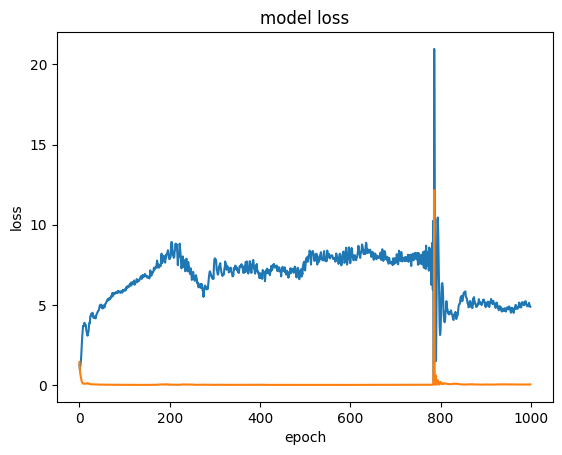

In [21]:
show_history(caries_gan_history, "fyp_caries_GAN1024")

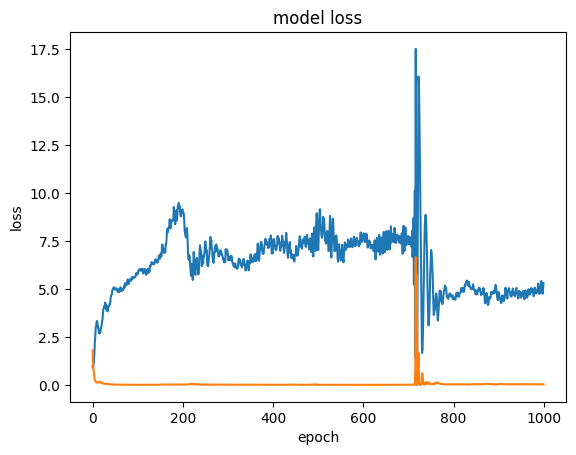

In [22]:
show_history(gingivitis_gan_history, "fyp_gingivitis_GAN1024")

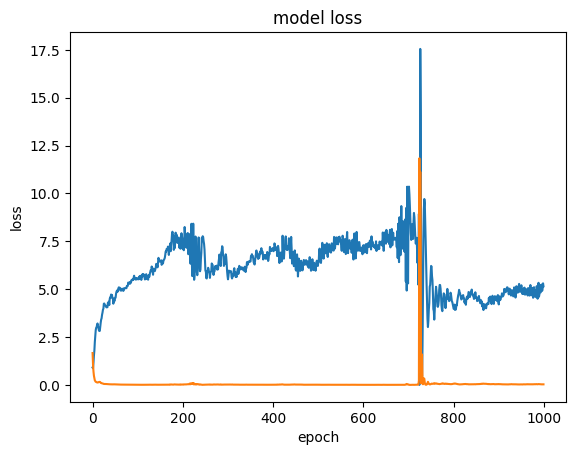

In [23]:
show_history(wsl_gan_history, "fyp_wsl_GAN1024")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


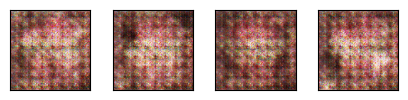

In [24]:
y_pred = caries_gan.generator.predict(fixed_noise)
show_images(y_pred)

In [25]:
# plt.imshow(y_pred[0])